# Introduction to Polynomial Chaos

Daniel A. Cline

A companion paper to this notebook can be found here: https://github.com/dcline1/PolynomialChaos

In [1]:
import numpy as np
import math

import numpy.polynomial.hermite_e as herm

from scipy.integrate import quad
from scipy.integrate import odeint

from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import beta

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Utility Functions for (Hermite) Polynomial Chaos Expansions

In [2]:
# Eq. (3.4) : Hermite polynomial: H_n(x)
def H(z, n):
    return herm.hermeval(z, n*[0]+[1])

# Eq. (3.5) : Numerical calculation of < H_m(z) H_n(z) > inner product
def inner_prod(m, n):
    f = lambda z : H(z, n) * H(z, m) * norm.pdf(z)
    return quad(f, -np.inf, np.inf)[0]

# Eq. (3.5) : Closed-form calculation of < H_m(x) H_n(x) > inner product
def inner_prod_closed(m, n):
    return 0 if m != n else math.factorial(n)

# Eq. (2.3) : Numerical calculation of < f(x) H_m(x) > inner product
def inner_prod_func(f, m, dom = None):
    if dom is None:
        dom = [-np.inf, np.inf]
    h = lambda z : f(z) * H(z, m) * norm.pdf(z)
    return quad(h, dom[0], dom[1])[0]

# Calculate the a_j coefficients in Eq. (2.4) usign Eq. (2.3)
def find_coef(f, p = 10, dom = None):
    a = []
    for i in range(p):
        ip = inner_prod_closed(i, i)
        ipf = inner_prod_func(f, i, dom)
        a.append(ipf/ip)
    return a

# Eq. (2.4) : Calculate f(z) given a_i, ..., a_p
def eval_poly(z, a):
    f = 0.0
    for i in range(len(a)):
        f += a[i] * H(z, i)
    return f

### Test Hermite Polynomial Function

H(x, n) = $H_n(x)$

H(x, 0) = $H_0(z) = 1$

H(x, 2) = $H_1(z) = z$

H(x, 3) = $H_2(z) = z^2 - 1$

H(x, 4) = $H_3(z) = z^3 - 3z$

In [3]:
z = np.linspace(-2.2,2.2,1000)

print('H_0 match: ', np.allclose(H(z, 0), 1))
print('H_1 match: ', np.allclose(H(z, 1), z))
print('H_2 match: ', np.allclose(H(z, 2), (z**2 - 1)))
print('H_3 match: ', np.allclose(H(z, 3), (z**3 - 3*z)))

H_0 match:  True
H_1 match:  True
H_2 match:  True
H_3 match:  True


### Test inner product function

The inner product has a closed-form solution for Hermite polynomials.

$$
\langle H_m(z) H_n(z) \rangle = \int_{-\infty}^{\infty} H_m(Z) H_n(z) \phi(z) dz = m! \delta_{mn}
$$

We compare our numerical calculation to the closed-form solution above to validate our implementation.

In [4]:
for m in range(11):
    for n in range(11):
        ip = inner_prod(m, n)
        if abs(ip) > 0.001:
            print("IP(%d, %d) = %.f, %d! = %.f" %(m, n, ip, m, inner_prod_closed(m, n)))

IP(0, 0) = 1, 0! = 1
IP(1, 1) = 1, 1! = 1
IP(2, 2) = 2, 2! = 2
IP(3, 3) = 6, 3! = 6
IP(4, 4) = 24, 4! = 24
IP(5, 5) = 120, 5! = 120
IP(6, 6) = 720, 6! = 720
IP(7, 7) = 5040, 7! = 5040
IP(8, 8) = 40320, 8! = 40320
IP(9, 9) = 362880, 9! = 362880
IP(10, 10) = 3628800, 10! = 3628800


Note that the inner products grow very rapidly as $m$ increases. This is important to keep in mind since numerical overflow becomes a problem as we increase the number of terms in the polynomial expansion.

### Exercise 3.a: Plot the first 3, 5, and 8 Hermite polynomials

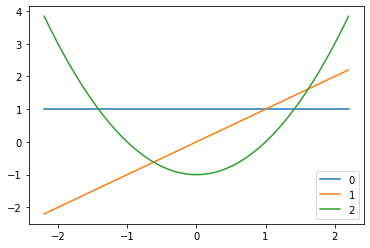

In [5]:
z = np.linspace(-2.2,2.2,1000)

for i in range(3):
    plt.plot(z, H(z, i), label=i)
plt.legend()
plt.show()

We see that the first is just a constant ($1$), the second is linear ($z$), and the third is a parabola ($z^2 - 1$).

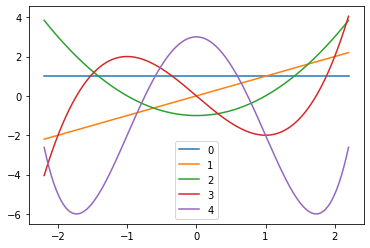

In [6]:
for i in range(5):
    plt.plot(z, H(z, i), label=i)
plt.legend()
plt.show()

As we add polynomials, we see that even-ordered polynomials (0, 2, 4, ...) are symmetric around 0, while odd-ordered (1, 3, 5, ...) are not.

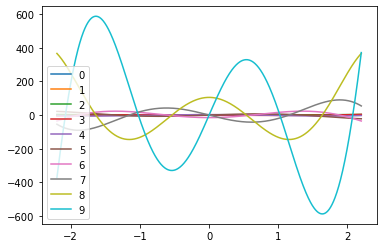

In [7]:
for i in range(10):
    plt.plot(z, H(z, i), label=i)
plt.legend()
plt.show()

As we add yet more, we see the higher-order polynomials grow very large very quickly.

### Exercise 3.b:

Construct the Hermite polynomial expansion of $f(z) = 10 + 2z$.

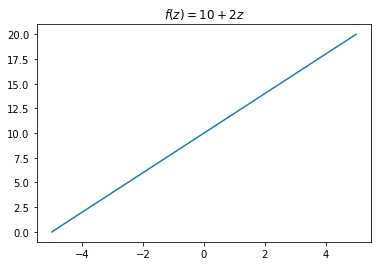

In [8]:
z = np.linspace(-5,5,1000)
f = lambda z : 10.0 + 2.0*z

f_z = f(z)

plt.plot(z, f_z)
plt.title("$f(z) = 10 + 2z$")
plt.show()

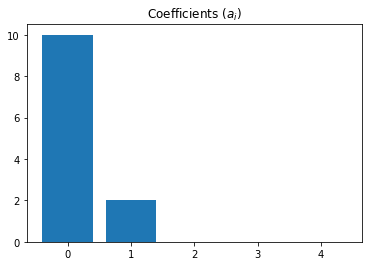

All coefficients valid? True


In [9]:
a = find_coef(f, p = 5)
plt.bar(range(len(a)), a)
plt.title('Coefficients ($a_i$)')
plt.show()

print('All coefficients valid?', not np.isnan(a).any())

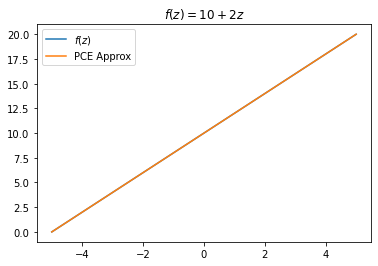

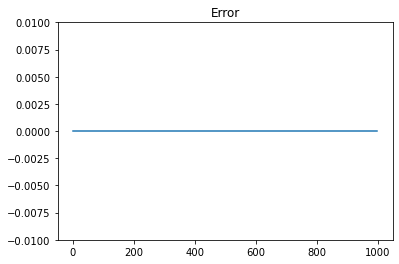

In [10]:
f_tilde = []
for i in range(len(z)):
    f_tilde.append(eval_poly(z[i], a))

plt.plot(z, f_z, label='$f(z)$')
plt.plot(z, f_tilde, label='PCE Approx')
plt.title("$f(z) = 10 + 2z$")
plt.legend()
plt.show()

plt.plot(f_tilde - f_z)
plt.ylim(-0.01, 0.01)
plt.title('Error')
plt.show()

This very simple function only requires a very low number for $p$. (Try $p = 2$).

## Example 3.c: Sinc function


Construct the Hermite polynomial expansion of $f(z) = \sin(4z)/z$.

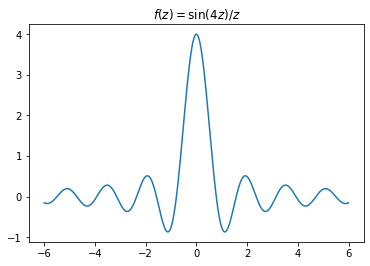

In [11]:
z = np.linspace(-6, 6, 1000)

def f_scalar(z):
    return np.sin(z*4)/z
f = np.vectorize(f_scalar)

f_z = f(z)

plt.plot(z, f(z))
plt.title("$f(z) = \sin(4z)/z$")
plt.show()

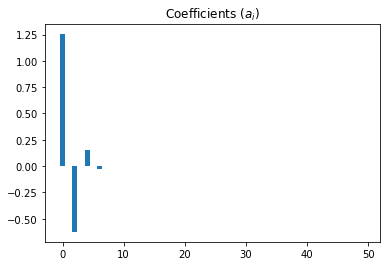

All coefficients valid? True


In [12]:
a = find_coef(f, p = 50)
plt.bar(range(len(a)), a)
plt.title('Coefficients ($a_i$)')
plt.show()

print('All coefficients valid?', not np.isnan(a).any())

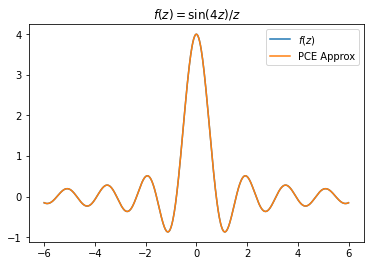

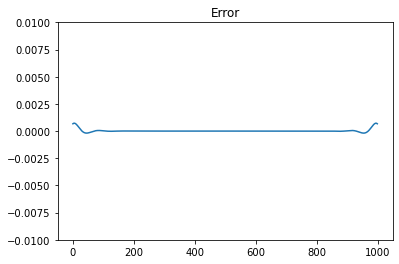

In [13]:
f_tilde = []
for i in range(len(z)):
    f_tilde.append(eval_poly(z[i], a))

plt.plot(z, f_z, label='$f(z)$')
plt.plot(z, f_tilde, label='PCE Approx')
plt.title("$f(z) = \sin(4z)/z$")
plt.legend()
plt.show()

plt.plot(f_tilde - f_z)
plt.ylim(-0.01, 0.01)
plt.title('Error')
plt.show()

This function requires a relatively large $p$ ($p = 50$), but it can still be approximated to high accuracy.

### Exercise 3.c:

Construct the Hermite polynomial expansion of $f(z) = |z|$.

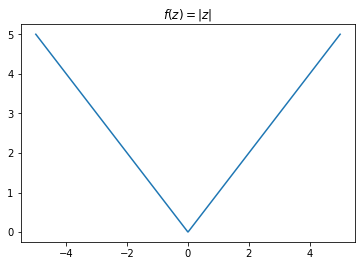

In [14]:
z = np.linspace(-5,5,1000)
f = lambda z : np.abs(z)

f_z = f(z)

plt.plot(z, f_z)
plt.title("$f(z) = |z|$")
plt.show()

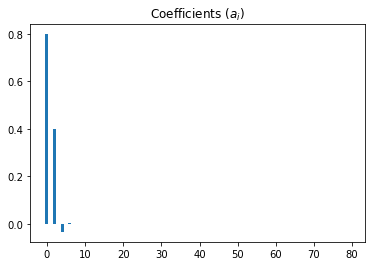

All coefficients valid? True


In [15]:
a = find_coef(f, p = 80)
plt.bar(range(len(a)), a)
plt.title('Coefficients ($a_i$)')
plt.show()

print('All coefficients valid?', not np.isnan(a).any())

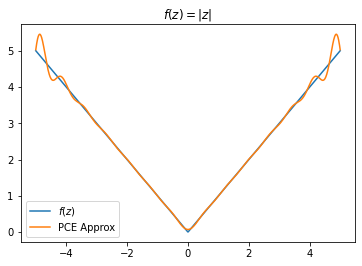

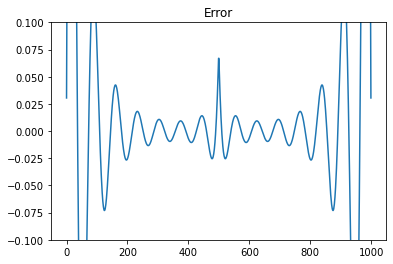

In [16]:
f_tilde = []
for i in range(len(z)):
    f_tilde.append(eval_poly(z[i], a))

plt.plot(z, f_z, label='$f(z)$')
plt.plot(z, f_tilde, label='PCE Approx')
plt.title("$f(z) = |z|$")
plt.legend()
plt.show()

plt.plot(f_tilde - f_z)
plt.ylim(-0.1, 0.1)
plt.title('Error')
plt.show()

We see the error grows as we move away from the origin and is still quite large for $p = 80$. Using a larger $p$ could theoretically reduce the error, but numerical errors produce invalid coefficients for large $p$. (Try $p = 100$).

## Polynomial Chaos Expansions of Random Variables

In [17]:
# Eq. (4.6) : Mean
def mean(a):
    return a[0]

# Eq. (4.7) : Variance
def var(a):
    total = 0.0
    for i in range(1, len(a)):
        total += (a[i]**2) * inner_prod_closed(i, i)
    return total

# Eq. (4.3) : Numerical calculation of inner product using uniform transformation
def inner_prod_func_u(f_inv, m):
    h = lambda u : f_inv(u) * H(norm.ppf(u), m)
    return quad(h, 0, 1)[0]

# Calculate the a_j coefficients in Eq. (4.4)
def find_coef_u(f_inv, p = 10):
    a = []
    for i in range(p):
        ip = inner_prod_closed(i, i)
        ipf = inner_prod_func_u(f_inv, i)
        a.append(ipf/ip)
    return a

# Eq. (4.5) : Calculate f(u) given a_i, ..., a_p
def eval_poly_u(u, a):
    f = 0.0
    for i in range(len(a)):
        f += a[i] * H(norm.ppf(u), i)
    return f

### Exercise 4.a

Construct the Hermite polynomial expansion of $f(Z) = Z$ where $Z \sim N(0,1)$. What are the values of the coefficients?

All random variables can be represented by polynomial chaos expansions. In the case of normal random variables, one typically uses Hermite polynomials, since the weighting function in the inner product is a standard normal density function.

a[0] = 0.000000
a[1] = 1.000000
a[2] = 0.000000
a[3] = 0.000000
a[4] = 0.000000
a[5] = -0.000000
a[6] = 0.000000
a[7] = -0.000000
a[8] = 0.000000
a[9] = 0.000000


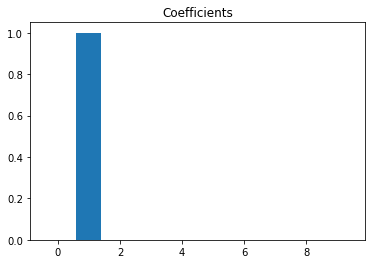

In [18]:
p = 10
f = lambda z : z

a = find_coef(f, p)
for i in range(p):
    print('a[%d] = %f' % (i, a[i]))

plt.bar(range(len(a)), a)
plt.title('Coefficients')
plt.show()

### Exercise 4.1.a

Calculate the mean and variance using the coefficients. Do they match the closed-form mean and variance of $f(Z)$?

In [19]:
print('Mean: ', mean(a))
print('Var: ', var(a))

Mean:  0.0
Var:  1.0000000000000022


Note that and $a_j = 0$ for $j > 1$ and we have

$E[Z] = a_0 = 0$

$Var(Z) = a_1^2 \langle H_1^2(z) \rangle = 1$    (since $\langle H_1^2(z) \rangle = 1$ and $a_j = 0$ for $j > 1$)

Therefore, normal random variables are fully described by the first two coefficients of their Hermite polynomial expansion.

### Example 4.b

Construct the Hermite polynomial expansion of $f(Z) = 10 + 2Z$ where $Z \sim N(0,1)$ (i.e. $f(Z) \sim N(10, 2^2)$). What are the values of the coefficients?

a[0] = 10.000000
a[1] = 2.000000
a[2] = 0.000000
a[3] = -0.000000
a[4] = -0.000000
a[5] = 0.000000
a[6] = -0.000000
a[7] = 0.000000
a[8] = 0.000000
a[9] = 0.000000


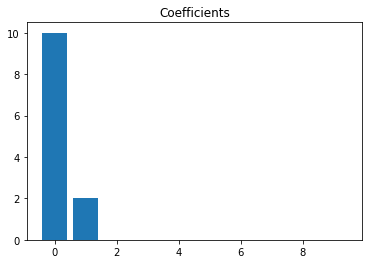

In [20]:
p = 10
f = lambda z : 10 + 2*z

a = find_coef(f, p)
for i in range(p):
    print('a[%d] = %f' % (i, a[i]))

plt.bar(range(len(a)), a)
plt.title('Coefficients')
plt.show()

### Exercise 4.1.b

Calculate the mean and variance using the coefficients. Do they match the closed-form mean and variance of $f(Z)$?

In [21]:
print('Mean: ', mean(a))
print('Var: ', var(a))

Mean:  9.999999999999996
Var:  4.000000000000009


Analogous to the above example,$E[f(Z)] = a_0 = 10$, $Var(f(Z)) = a_1^2 = 4$, and $a_j = 0$ for $j > 1$.

### Example 4.c

Construct the Hermite polynomial expansion of $f(Z) = e^{\mu + \sigma Z}$, where $\mu = 1$, $\sigma = 0.1$, and $Z \sim N(0,1)$. What are the values of the coefficients?

a[0] = 2.731907
a[1] = 0.273191
a[2] = 0.013660
a[3] = 0.000455
a[4] = 0.000011
a[5] = 0.000000
a[6] = 0.000000
a[7] = 0.000000
a[8] = 0.000000
a[9] = 0.000000


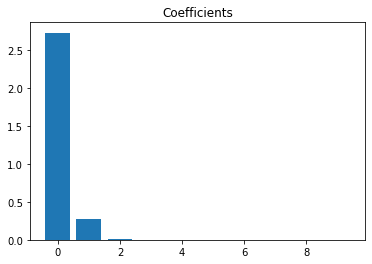

In [22]:
p = 10 
f = lambda z : np.exp(1.0 + 0.1*z)

a = find_coef(f, p)
for i in range(p):
    print('a[%d] = %f' % (i, a[i]))

plt.bar(range(len(a)), a)
plt.title('Coefficients')
plt.show()

### Exercise 4.1.c

Calculate the mean and variance using the coefficients. Do they match the closed-form mean and variance of $f(Z)$?

In [23]:
print('Mean: ', mean(a))
print('Var: ', var(a))

Mean:  2.731907272825927
Var:  0.07500758634272808


This compares to

$$
E[f(Z)] = exp \left( \mu + \sigma^2/2 \right) = 2.731907
$$

which is equal to $a[0]$ and 

$$
Var(f(Z)) = \left[ e^{\sigma^2} - 1 \right] e^{2 \mu + \sigma^2} = 0.075008
$$

which is equal to 

$$
\sum_{j = 1}^{\infty} a_j^2 \langle H_j^2(z) \rangle = \sum_{j = 1}^{\infty} a_j^2 j! = a[1]^2 + 2 a[2]^2 + 6 a[3]^2 + 24 a[4]^2 + ... = 0.075008
$$

### Exercise 4.1.c (Extra)

We can also use the polynomial expansion to transform samples of a random variable with one distribution into samples of another random variable with a different distribution. For example, we start with $N$ samples of a standard normal random variable.

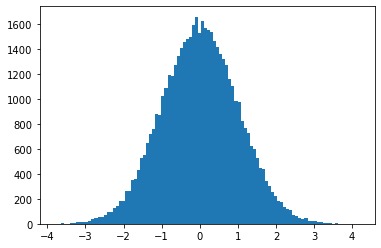

In [24]:
np.random.seed(123)
N = 50000
Z = np.random.normal(loc=0, scale=1, size=N)
plt.hist(Z, bins=100)
plt.show()

Using the coefficients we solved for in Exercise 4.1.c, we can evaluate the Hermite polynomial expansion to transform each $z_i$ into $f(z_i) = e^{\mu + \sigma z_i}$ using the polynomial expansion.

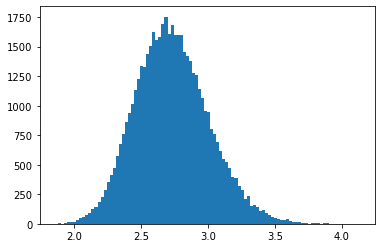

Sample mean: 2.73360936986651
Sample variance: 0.0751880143590275


In [25]:
f_tilde = []
for i in range(len(Z)):
    f_tilde.append(eval_poly(Z[i], a))
    
plt.hist(f_tilde, bins=100)
plt.show()

print('Sample mean:', np.mean(f_tilde))
print('Sample variance:', np.var(f_tilde))

From the above plots, we see that we can use the polynomial chaos expansion of a random variable to transform a normal random variable $Z \sim N(0, 1)$ into a lognormal random varialbe $Y = LogNorm(1.0, 0.1)$. Of course we could have done this more easily by just plugging $Z$ into $f(Z) = e^{\mu + \sigma Z}$ (done below for comparison), so we have yet to see the full power of polynomial expansions.

However, we did see that once we have the coefficients, we can calculate the expected value and variance of the transformed random variable, regardless of the polynomials used or the exact function used for the transformation. We will see that this is very powerful when calculating the mean and variance of stochastic processes.

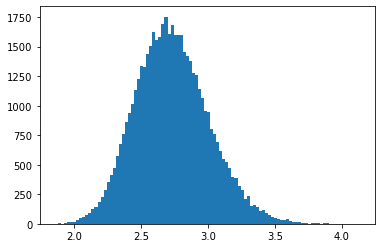

Sample mean: 2.73360936986651
Sample variance: 0.0751880143590275

Same?  True


In [26]:
f_z = []
for i in range(len(Z)):
    f_z.append(f(Z[i]))

plt.hist(f_z, bins=100)
plt.show()

print('Sample mean:', np.mean(f_tilde))
print('Sample variance:', np.var(f_tilde))

print()
print('Same? ', np.allclose(f_tilde, f_z))

### Exercise 4.d

Using the uniform transformation, construct the Hermite polynomial expansion of $f(Z) = e^{\mu + \sigma Z}$, where $\mu = 1$, $\sigma = 0.1$, and $Z \sim N(0,1)$. What are the values of the coefficients?

a[0] = 2.731907
a[1] = 0.273191
a[2] = 0.013660
a[3] = 0.000455
a[4] = 0.000011
a[5] = 0.000000
a[6] = 0.000000
a[7] = 0.000000
a[8] = 0.000000
a[9] = -0.000000


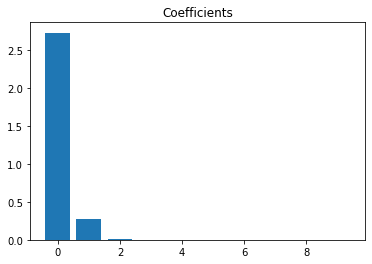

In [27]:
p = 10 

mu = 1.0
sigma = 0.1
f_inv = lambda u : lognorm.ppf(u, s=sigma, scale=np.exp(mu))

a = find_coef_u(f_inv, p)
for i in range(p):
    print('a[%d] = %f' % (i, a[i]))

plt.bar(range(len(a)), a)
plt.title('Coefficients')
plt.show()

Note that the coefficients have the same value as those in Exercise 4.c.

### Exercise 4.1.d

Calculate the mean and variance using the coefficients. Do they match the closed-form mean and variance of $f(Z)$?

In [28]:
print('Mean: ', mean(a))
print('Var: ', var(a))

Mean:  2.7319072728267635
Var:  0.07500758634835837


As in Exercise 4.1.c, these  match the closed-form mean and variance. Note that the mean and variance are a function of only the coefficients.

### Exercise 4.1.d (Extra)

We can also use the polynomial expansion to transform samples of a **uniform** random variable into samples of $f(Z)$. For example, we start with $N$ samples of a uniform(0, 1) random variable.

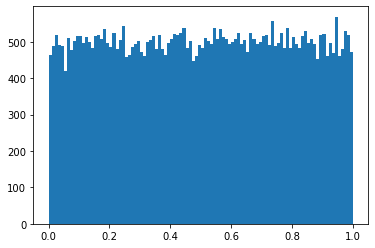

In [29]:
np.random.seed(123)
N = 50000
U = np.random.uniform(size=N)
plt.hist(U, bins=100)
plt.show()

Using the coefficients we solved for in Exercise 4.1.d, we can evaluate the Hermite polynomial expansion to transform each $u_i$ into $f(u_i) = e^{\mu + \sigma z_i}$, where $z_i = F_Z^{-1}(u_i)$, using the polynomial expansion.

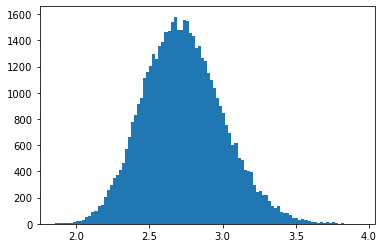

Sample mean: 2.733188849258942
Sample variance: 0.07411136606239582


In [30]:
f_tilde = []
for i in range(len(U)):
    f_tilde.append(eval_poly_u(U[i], a))
    
plt.hist(f_tilde, bins=100)
plt.show()

print('Sample mean:', np.mean(f_tilde))
print('Sample variance:', np.var(f_tilde))

### Exercise 4.e

Using the uniform transformation, construct the Hermite polynomial expansion of $Y \sim Beta(\alpha, \beta)$, where $\alpha = \beta = 0.5$. What are the values of the coefficients?

a[0] = 0.500000
a[1] = 0.335320
a[2] = 0.000000
a[3] = -0.039584
a[4] = 0.000000
a[5] = 0.004220
a[6] = -0.000000
a[7] = -0.000358
a[8] = -0.000000
a[9] = 0.000025
a[10] = 0.000000
a[11] = -0.000001
a[12] = 0.000000
a[13] = 0.000000
a[14] = -0.000000
a[15] = -0.000000
a[16] = -0.000000
a[17] = 0.000000
a[18] = 0.000000
a[19] = -0.000000
a[20] = -0.000000
a[21] = 0.000000
a[22] = 0.000000
a[23] = -0.000000
a[24] = 0.000000
a[25] = 0.000000
a[26] = 0.000000
a[27] = -0.000000
a[28] = -0.000000
a[29] = 0.000000


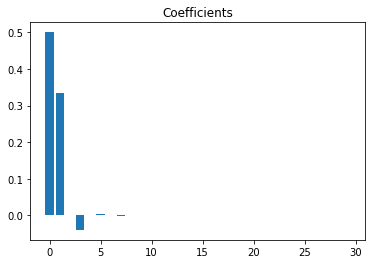

In [31]:
p = 30

mu = 1.0
sigma = 0.1
f_inv = lambda u : beta.ppf(u, a=0.5, b=0.5)

a = find_coef_u(f_inv, p)
for i in range(p):
    print('a[%d] = %f' % (i, a[i]))

plt.bar(range(len(a)), a)
plt.title('Coefficients')
plt.show()

### Exercise 4.1.e

Calculate the mean and variance using the coefficients. Do they match the closed-form mean and variance of $Y$?

In [32]:
print('Mean: ', mean(a))
print('Var: ', var(a))

Mean:  0.5
Var:  0.1249999149015917


The closed-form mean and variance are given by:

$$
E[Y] = \frac{\alpha}{\alpha + \beta} = 0.5
$$

$$
Var(y) = \frac{ \alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)} = 0.125
$$

We see the polynomial chaos mean and variance match the closed-form results.

### Exercise 4.1.e (Extra)

We can also use the polynomial expansion to transform samples of a uniform random variable into samples of $Y$. For example, we start with $N$ samples of a uniform(0, 1) random variable.

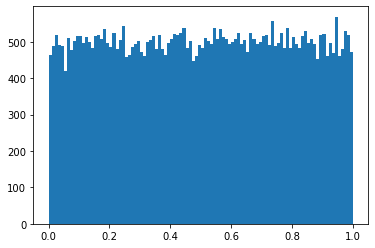

In [33]:
np.random.seed(123)
N = 50000
U = np.random.uniform(size=N)
plt.hist(U, bins=100)
plt.show()

Using the coefficients we solved for in Exercise 4.1.e, we can evaluate the Hermite polynomial expansion to transform each $u_i$ into $y_i$ using the polynomial expansion.

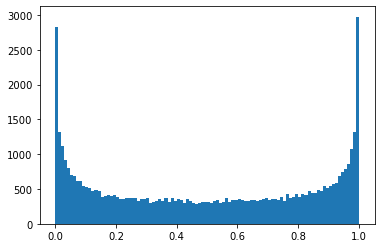

Sample mean: 0.5019653340480946
Sample variance: 0.12465895143809722


In [34]:
f_tilde = []
for i in range(len(U)):
    f_tilde.append(eval_poly_u(U[i], a))
    
plt.hist(f_tilde, bins=100)
plt.show()

print('Sample mean:', np.mean(f_tilde))
print('Sample variance:', np.var(f_tilde))

## Polynomial Chaos Expansion of Functions with Stochastic Parameters

In [35]:
def triple_prod(l, m, n):
    f = lambda x : H(x, l) * H(x, m) * H(x, n) * norm.pdf(x)
    return quad(f, -np.inf, np.inf)[0]

def triple_prod_closed(i, j, k):
    s = (i + j + k)//2
    if s >= i and s >= j and s >= k:
        tp = math.factorial(i)*math.factorial(j)*math.factorial(k)
        tp /= math.factorial(s-i)*math.factorial(s-j)*math.factorial(s-k)
        return tp
    return 0

### Test triple production function:

$$
\langle H_i(z) H_j(z) H_k(z) \rangle = = \int_{-\infty}^{\infty} H_i(Z) H_j(z) H_k(z) \phi(z) dz = \frac{i! j! k!}{(s-i)! (s-j)! (s-k)!}
$$
 
where $s \geq \min\{i, j, k\}$ and $s = (i + j + k)/2$ is even. 

In [36]:
for i in range(4):
    for j in range(4):
        for k in range(4):
            tp = triple_prod(i, j, k)
            if abs(tp) > 0.001:
                tp_fact = triple_prod_closed(i, j, k)
                print("TP(%d, %d, %d) = %.f, closed-form = %.f" %(i, j, k, tp, tp_fact))

TP(0, 0, 0) = 1, closed-form = 1
TP(0, 1, 1) = 1, closed-form = 1
TP(0, 2, 2) = 2, closed-form = 2
TP(0, 3, 3) = 6, closed-form = 6
TP(1, 0, 1) = 1, closed-form = 1
TP(1, 1, 0) = 1, closed-form = 1
TP(1, 1, 2) = 2, closed-form = 2
TP(1, 2, 1) = 2, closed-form = 2
TP(1, 2, 3) = 6, closed-form = 6
TP(1, 3, 2) = 6, closed-form = 6
TP(2, 0, 2) = 2, closed-form = 2
TP(2, 1, 1) = 2, closed-form = 2
TP(2, 1, 3) = 6, closed-form = 6
TP(2, 2, 0) = 2, closed-form = 2
TP(2, 2, 2) = 8, closed-form = 8
TP(2, 3, 1) = 6, closed-form = 6
TP(2, 3, 3) = 36, closed-form = 36
TP(3, 0, 3) = 6, closed-form = 6
TP(3, 1, 2) = 6, closed-form = 6
TP(3, 2, 1) = 6, closed-form = 6
TP(3, 2, 3) = 36, closed-form = 36
TP(3, 3, 0) = 6, closed-form = 6
TP(3, 3, 2) = 36, closed-form = 36


### Exercise 5.a

Assuming $r \sim N(\mu, \sigma^2)$, where $\mu = 0.2$ and $\sigma = 0.05$, and $v_0 = 3$, draw $N = 10,000$ random realizations of $r$, and for each one, evaluate (5.1) numerically over $t = [0, 10]$ using $10,000$ timesteps. Calculate the sample mean and standard deviation at each timestep. Plot all model runs, along with the mean and 95\% confidence intervals through time.

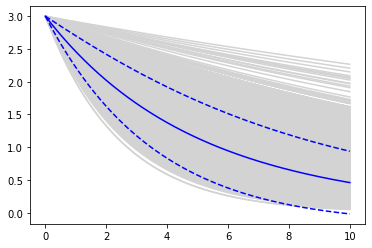

In [37]:
t = np.linspace(0., 10., 10001)

N = 10000
r_mc = []
v_mc = []

v0 = 3.0
for i in range(N):
    r = np.random.normal(loc=0.2, scale=0.05)
    r_mc.append(r)
    sol = odeint(lambda v, t : -r*v, v0, t)
    v_mc.append(sol)

v_mc_mean = np.mean(v_mc, axis = 0)
v_mc_stdev = np.std(v_mc, axis = 0)
#v_mc_5pct = np.percentile(v_mc, q = 5, axis = 0)
#v_mc_95pct = np.percentile(v_mc, q = 95, axis = 0)

for i in range(len(v_mc)):
    plt.plot(t, v_mc[i], 'lightgray')
plt.plot(t, v_mc_mean, 'b')
plt.plot(t, v_mc_mean + 1.96 * v_mc_stdev, 'b--')
plt.plot(t, v_mc_mean - 1.96 * v_mc_stdev, 'b--')
#plt.plot(t, v_mc_5pct, 'r--')
#plt.plot(t, v_mc_95pct, 'r--')
plt.show()

## Intrusive Approach

### Exercise 5.b

Construct the Hermite polynomial expansion of $r \sim N(\mu, \sigma^2)$, where $\mu = 0.2$ and $\sigma = 0.05$ for $p = 10$. What are the values of the coefficients?

ra[0] = 0.500000
ra[1] = 0.335320
ra[2] = 0.000000
ra[3] = -0.039584
ra[4] = 0.000000
ra[5] = 0.004220
ra[6] = -0.000000
ra[7] = -0.000358
ra[8] = -0.000000
ra[9] = 0.000025


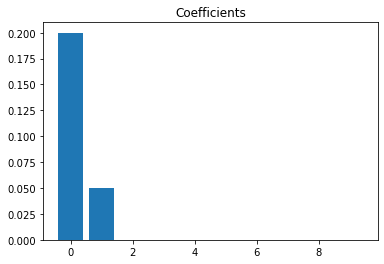

In [38]:
p = 10 

mu = 0.2
sigma = 0.005
f_inv = lambda u : norm.ppf(u, loc=0.2, scale=0.05)

ra = find_coef_u(f_inv, p)
for i in range(p):
    print('ra[%d] = %f' % (i, a[i]))

plt.bar(range(len(ra)), ra)
plt.title('Coefficients')
plt.show()

### Exercise 5.c

Using the coefficients from 5.b and (5.8), construct the $A$ in (5.9)  for the example model (5.1) and solve the system of equations. Plot the solutions (coefficients) through time. Calculate the mean and standard deviation through time using the solutions of the system of ODEs. Plot the mean and 95\% confidence intervals through time. Compare with the monte carlo results in 5.a.

In [39]:
# set up ODE matrix
A = np.zeros((p,p))

for k in range(p):
    ip = inner_prod_closed(k, k)
    for j in range(p):
        for i in range(p):
            tp = triple_prod_closed(i, j, k)
            A[j,k] += -ra[i] * tp/ip

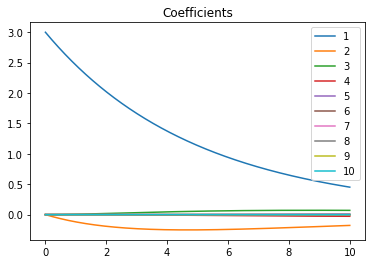

In [40]:
# solve ODE
v0 = np.zeros(n)
v0[0] = 3.0
v_pc = odeint(lambda v,t : A@v, v0, t)

plt.plot(t, v_pc)
plt.title('Coefficients')
plt.legend(range(1,v_pc.shape[1]+1))
plt.show()

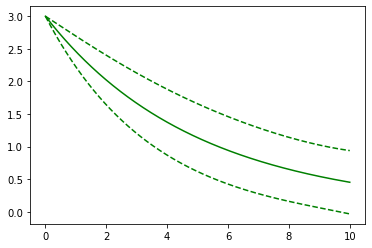

In [41]:
v_pc_mean = v_pc[:,0]  # the first coefficient through time is the solution of first ODE

v_pc_var = 0.0
for i in range(1, n):
    ip = inner_prod_closed(i, i)
    v_pc_var += v_pc[:,i]**2 * ip     # coefficients 2,...,p are the solutions to remaining ODE's

v_pc_stdev = np.sqrt(v_pc_var)

plt.plot(t, v_pc_mean, 'g')
plt.plot(t, v_pc_mean + 1.96*v_pc_stdev, 'g--')
plt.plot(t, v_pc_mean - 1.96*v_pc_stdev, 'g--')
plt.show()

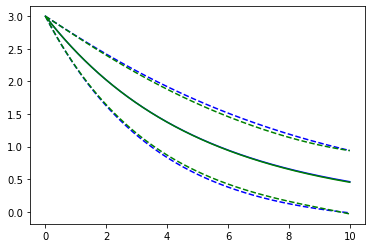

In [42]:
# compare solutions
plt.plot(t, v_mc_mean, 'b')
plt.plot(t, v_mc_mean + 1.96*v_mc_stdev, 'b--')
plt.plot(t, v_mc_mean - 1.96*v_mc_stdev, 'b--')

plt.plot(t, v_pc_mean, 'g')
plt.plot(t, v_pc_mean + 1.96*v_pc_stdev, 'g--')
plt.plot(t, v_pc_mean - 1.96*v_pc_stdev, 'g--')

plt.show()

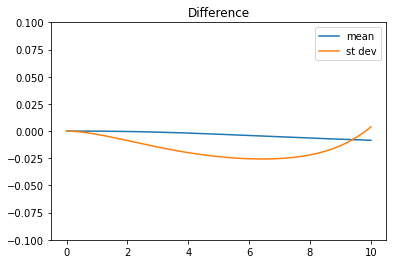

In [43]:
mean_diff = v_pc_mean - v_mc_mean.T.squeeze()
stdev_diff = v_pc_stdev - v_mc_stdev.T.squeeze()

plt.plot(t, mean_diff, label="mean")
plt.plot(t, stdev_diff, label="st dev")
plt.title("Difference")
plt.legend()
plt.ylim(-0.1, 0.1)
plt.show()

## Non-Intrusive Approach

### Exercise 5.d

- Taking $N = 100$, construct the vector $z_i = F_Z^{-1}(u_i)$, where $u_i = (i + 0.5)/N$ are equally spaced points over the interval $(0, 1)$.

- For each $z_i$, calculate $r_i = 0.2 + 0.05 x_i$ and evaluate (5.1) numerically over $t = [0, 10]$ using $10,000$ timesteps.

- Construct the design matrix $\Psi(z)$ using $\{ z_1, ..., z_N \}$ and Hermite polynomials as the orthogonal polynomial basis.

- For each timestep, solve for the coefficients $(a_1, ..., a_p)$ using linear regression such that the coefficients are functions of time $(a_1(t), ..., a_p(t))$.

- Plot the solutions (coefficients) through time.

- Calculate the mean and standard deviation through time using the coefficients. Plot the mean and 95\% confidence intervals through time.

- Compare with the monte carlo results in 5.a.

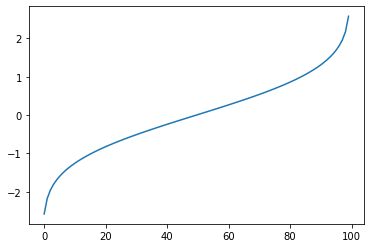

In [44]:
N = 100
Z = []
for i in range(N):
    Z.append(norm.ppf(i/N + 0.5/N))
Z = np.array(Z)
plt.plot(Z)
plt.show()

Run the model.

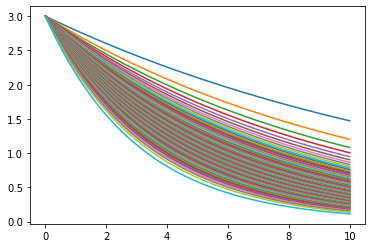

In [45]:
t = np.linspace(0., 10., 10001)

v_train = []

v0 = 3.0
for i in range(len(Z)):
    r = 0.2 + 0.05*Z[i]
    sol = odeint(lambda v, t : -r*v, v0, t)
    v_train.append(sol[:,0])
v_train = np.stack(v_train).T

plt.plot(t, v_train)
plt.show()

 Construct the design matrix using Hermite polynomials up to degree $p$.

In [46]:
p = 10

Psi = []
for i in range(p):
    Psi.append(H(Z,i))
Psi = np.stack(Psi).T
Psi.shape

(100, 10)

In [47]:
Psi[:5,:5] # show upper left corner

array([[ 1.        , -2.5758293 ,  5.6348966 , -9.36287318,  7.2124733 ],
       [ 1.        , -2.17009038,  3.70929225, -3.70931866, -3.07832001],
       [ 1.        , -1.95996398,  2.84145882, -1.64922898, -5.29194705],
       [ 1.        , -1.81191067,  2.28302029, -0.51280748, -5.91989952],
       [ 1.        , -1.69539771,  1.8743734 ,  0.21298706, -5.98421796]])

Run the regression

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

a_t = []
v_lr =[]
for i in range(v_train.shape[0]):
    lr = LinearRegression(fit_intercept=False)
    lr.fit(Psi, v_train[i])
    a_t.append(lr.coef_)
    v_lr.append(lr.predict(Psi))
v_lr = np.stack(v_lr)
a_t = np.stack(a_t)

Plot $a_i(t)$ coefficients through time.

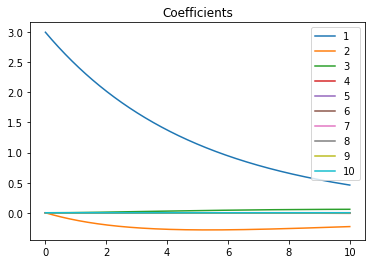

In [49]:
plt.plot(t, a_t)
plt.title('Coefficients')
plt.legend(range(1,a_t.shape[1]+1))

plt.show()

Compare original model and PCE results.

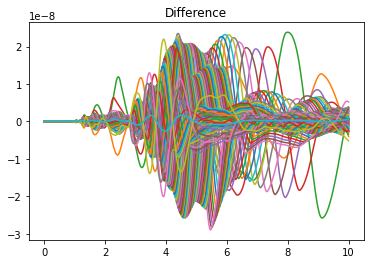

True

In [50]:
plt.plot(t, v_train - v_lr)
plt.title("Difference")
plt.show()

np.allclose(v_train, v_lr)

Calculate the mean and standard deviation using the coefficients and plot the mean and 95\% confidence intervals through time.

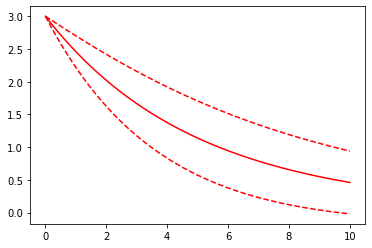

In [51]:
def mean_t(a_t):
    return a_t[:,0] # a_0(t) for all t

def var_t(a_t):
    total = 0.0
    for i in range(1, a_t.shape[1]):
        total += (a_t[:,i]**2) * inner_prod(i, i)
    return total

v_lr_mean = mean_t(a_t)
v_lr_stdev = np.sqrt(var_t(a_t))

plt.plot(t, v_lr_mean, 'r')
plt.plot(t, v_lr_mean + 1.96 * v_lr_stdev, 'r--')
plt.plot(t, v_lr_mean - 1.96 * v_lr_stdev, 'r--')
plt.show()

Plot the results from Exercises 5.a and 5.d for comparison.

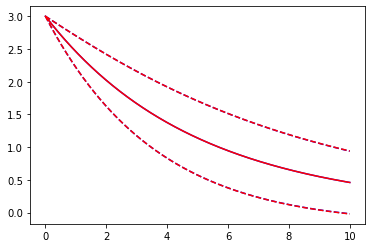

In [52]:
plt.plot(t, v_mc_mean, 'b')
plt.plot(t, v_mc_mean + 1.96*v_mc_stdev, 'b--')
plt.plot(t, v_mc_mean - 1.96*v_mc_stdev, 'b--')

#plt.plot(t, v_pc_mean, 'g')
#plt.plot(t, v_pc_mean + 1.96*v_pc_stdev, 'g--')
#plt.plot(t, v_pc_mean - 1.96*v_pc_stdev, 'g--')

plt.plot(t, v_lr_mean, 'r')
plt.plot(t, v_lr_mean + 1.96 * v_lr_stdev, 'r--')
plt.plot(t, v_lr_mean - 1.96 * v_lr_stdev, 'r--')

plt.show()

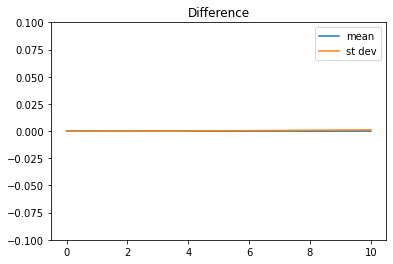

In [53]:
mean_diff = v_lr_mean - v_mc_mean.T.squeeze()
stdev_diff = v_lr_stdev - v_mc_stdev.T.squeeze()

plt.plot(t, mean_diff, label="mean")
plt.plot(t, stdev_diff, label="st dev")
plt.title("Difference")
plt.legend()
plt.ylim(-0.1, 0.1)
plt.show()

The results align.